In [73]:
from concurrent import futures
import nltk
from nltk.corpus import reuters, stopwords
from scipy import sparse
import string
from collections import defaultdict, Counter
import numpy as np
import os
import sys

from nltk.tokenize import word_tokenize
import sklearn
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.util import ngrams
import re
NUM_THREADS = 24

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

reuters_freqThreshold = 5000
shakespeare_freqThreshold = 5000

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/sanchitsinha/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanchitsinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanchitsinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reuters Data Scrubbing

In [16]:
all_files = reuters.fileids()
file_count = len(all_files)
print(len(reuters.fileids()))
punctuation = string.punctuation.replace("'", "")
stopset = set(stopwords.words("english"))

def thread_task(rawWords):
    freqMap = defaultdict(int)
    #convert to lowercase
    lower = [word.lower() for word in rawWords]
    
    #remove punctuation from tokens
    punc_filter = str.maketrans('', '', punctuation)
    stripped = [word.translate(punc_filter) for word in lower]
    
    #remove remaining alphanumerics
    words = [word for word in stripped if word.isalpha()]
    
    #filter out basic stopwords
    cleaned_word_bank = [word for word in words if word not in stopset]
    
    for word in cleaned_word_bank:
        freqMap[word] += 1
    return freqMap

def thread_exec(WORDS):
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
        results = list(ex.map(thread_task, WORDS))
    return results


10788


In [17]:
freqMap = defaultdict(int)
REUTERS_WORDS = [[str(word) for word in reuters.words(file)] for file in reuters.fileids()]
t = thread_exec(REUTERS_WORDS)
for ifreqMap in t:
    for k in ifreqMap.keys():    
        freqMap[k] += ifreqMap[k]    
        
freqTuples = list(freqMap.items())
sorted_freq = freqTuples.sort(key= lambda x: x[1], reverse=True)
topTuples_r = freqTuples[:reuters_freqThreshold]
filtered_vocab = [tup[0] for tup in topTuples_r]
reuters_vocab_np = np.asarray(filtered_vocab, dtype='str')
print(reuters_vocab_np.shape)

(5000,)


## Shakespeare Data Scrubbing

In [18]:
folder = './Shake_works'
sub = "[^a-zA-Z' ]+"
all_files = [file for t,y, file in os.walk(folder)][0]
stopset = set(stopwords.words("english"))

def thread_task(rawWords):
    freqMap = defaultdict(int)
    words = [re.sub(sub, '', word) for word in rawWords]
    lower = [word.lower() for word in words]
    words = [word for word in lower if word.isalpha()]
    cleaned_word_bank = [word for word in words if word not in stopset]    
    
    for word in cleaned_word_bank:
        freqMap[word] += 1
    return freqMap

def thread_exec(WORDS):
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
        results = list(ex.map(thread_task, WORDS))
    return results
    

In [19]:
freqMap = defaultdict(int)
SHAKESPEARE_WORDS = [[str(word) for word in open(folder+'/'+file).read().split()] for file in all_files]
t = thread_exec(SHAKESPEARE_WORDS)
for ifreqMap in t:
    for k in ifreqMap.keys():    
        freqMap[k] += ifreqMap[k]   
        
freqTuples = list(freqMap.items())
sorted_freq = freqTuples.sort(key= lambda x: x[1], reverse=True)
topTuples_s = freqTuples[:shakespeare_freqThreshold]
filtered_vocab = [tup[0] for tup in topTuples_s]
shakespeare_vocab_np = np.asarray(filtered_vocab, dtype='str')
print(shakespeare_vocab_np.shape)

(5000,)


## Outputting top words/frequencies to a file

In [20]:
reuters_freq_file = open("reuters_frequencies.txt", "w+")
shakes_freq_file = open("shakes_frequencies.txt", "w+")

for tup in topTuples_r:
    reuters_freq_file.write(f"{tup[0]}, {tup[1]}")
for tup in topTuples_s:
    shakes_freq_file.write(f"{tup[0]}, {tup[1]}")
    
reuters_freq_file.close()
shakes_freq_file.close()

# PreProcessing

In [21]:
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

vocab = reuters_vocab_np
tmp = list()
for word in shakespeare_vocab_np:
    if(word not in vocab):
        tmp.append(word)
vocab = np.append(vocab, tmp)
print(vocab.shape)


shakespeare_data = []
i=0
punc_filter = str.maketrans('', '', punctuation)
progress = IntProgress(min=0, max=len(SHAKESPEARE_WORDS))
label = HTML()
box = VBox(children=[label, progress])
display(box)
for doc in SHAKESPEARE_WORDS:
    shakespeare_data.append(np.zeros(vocab.shape))
    #print(doc)
    for word in doc:
        word = re.sub(sub,'',word).lower()
        shakespeare_data[i][vocab==word] = 1.0
    i+=1
    progress.value += 1
    label.value = u'{name}: {index} / {size}'.format(
                        name="Docs",
                        index=i,
                        size=len(SHAKESPEARE_WORDS)
                    )
shakespeare_data = np.array(shakespeare_data)   


reuters_data = []
i=0
punc_filter = str.maketrans('', '', punctuation)
progress = IntProgress(min=0, max=len(REUTERS_WORDS))
label = HTML()
box = VBox(children=[label, progress])
display(box)
for doc in REUTERS_WORDS:
    reuters_data.append(np.zeros(vocab.shape))
    for word in doc:
        word = word.lower()
        word = word.translate(punc_filter)
        reuters_data[i][vocab==word] = 1.0
    i+=1   
    progress.value += 1
    label.value = u'{name}: {index} / {size}'.format(
                        name="Docs",
                        index=i,
                        size=len(REUTERS_WORDS)
                    )
reuters_data = np.array(reuters_data)


(8586,)


In [25]:
X = shakespeare_data
y = np.zeros(X.shape[0])

X = np.concatenate((X, reuters_data), axis=0)
y = np.concatenate((y, np.ones(reuters_data.shape[0])), axis=0)

vocab = np.array(vocab, dtype=np.str)

print(X.shape)
print(y.shape)

X.dump('X')
y.dump('y')
vocab.dump('vocab')

(10830, 8586)
(10830,)


# Training

In [26]:
X = np.load('X')
y = np.load('y')
vocab = np.load('vocab')
Model_List = list()


In [27]:
def difference(l1,l2):
    precisionError = len([b for a,b in zip(l1,l2) if b != a and b == 0 and a == 1])
    recallError = len([b for a,b in zip(l1,l2) if b != a and b == 1 and a == 0])
    print("Precision Error is " + str(precisionError))
    print("Recall Error is " + str(recallError))

    return (precisionError) + (recallError)

def runModels(clf, Xtr, Ytr):
    kf = KFold(n_splits=5)    
    differencesB = []
    differencesG = []

    for train_index, test_index in kf.split(Xtr):
        x_train, x_test = [Xtr[i] for i in train_index], [Xtr[i] for i in test_index]
        y_train, y_test = [Ytr[i] for i in train_index], [Ytr[i] for i in test_index]    
        clf.fit(x_train,y_train)
        print(clf.predict(x_test))
        Model_List.append(clf)
        differencesB.append(difference(clf.predict(x_test), y_test) / len(y_test))
    print()
    return differencesB, differencesG

In [28]:
print(runModels(BernoulliNB(), X, y))
print(runModels(GaussianNB(), X, y))
#print(runModels)

/Users/sanchitsinha/Documents/UCI/cs178/cs178Venv/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


[1. 1. 1. ... 1. 1. 1.]
Precision Error is 42
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0

([0.019390581717451522, 0.0, 0.0, 0.0, 0.0], [])
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 42
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0
[1. 1. 1. ... 1. 1. 1.]
Precision Error is 0
Recall Error is 0

([0.019390581717451522, 0.0, 0.0, 0.0, 0.0], [])


# Validation

In [29]:
# custom k-fold cross validation code
# custom k-fold cross validation code

# def k_fold(X, Y1, Y2,folds)
#     split_size = X.shape[0]//folds
#     splits = []
#     for i in range(folds):
#         start = split_size*i
#         end = (split_size*(i+1))
#         validation = (X[start:end,], Y[start:end])
#         train_x = np.append(X[:start,], X[end:,])
#         train_y = np.append(Y[:start],Y[end:])
#         training = (np.atleast_2d(train_x).T, train_y)
#         splits.append((training, validation))
#     return splits

fold_error = []
print("seperating start")
X_s = X[y==0]
X_r = X[y==1]

Y_s = np.zeros(X_s.shape[0])
Y_r = np.ones(X_r.shape[0])

print("seperated docs")

## 5 -> 8 shakespere docs
## 5 -> ~2k reuters docs
folds = KFold(n_splits=5, random_state=None, shuffle=False)
splits = []
training_sx = []
training_sy = []

validation_sx = []
validation_sy = []


training_rx = []
training_ry = []
validation_rx = []
validation_ry = []

differencesB = []


print("splitting shakespere")
for train_index, test_index in folds.split(X_s, Y_s):
    x_tr, x_validation = X_s[train_index], X_s[test_index]
    y_tr, y_validation = Y_s[train_index], Y_s[test_index]
    training_sx.append(x_tr)
    training_sy.append(y_tr)
    validation_sx.append(x_validation) 
    validation_sy.append(y_validation)
print("split shakespeare done")
    
for train_index, test_index in folds.split(X_r, Y_r):
    x_tr, x_validation = X_r[train_index], X_r[test_index]
    y_tr, y_validation = Y_r[train_index], Y_r[test_index]
    training_rx.append(x_tr)
    training_ry.append(y_tr)
    validation_rx.append(x_validation) 
    validation_ry.append(y_validation)
print("split shakespere done")

print("training")

print(training_rx[0])
def validate(clf, name):
    for i in range(len(training_sx)):
        training_global_x = (np.concatenate((training_sx[i], training_rx[i]), axis=0))
        training_global_y = (np.concatenate((training_sy[i], training_ry[i]), axis=0))
        validation_global_x = (np.concatenate((validation_sx[i], validation_rx[i]), axis=0))
        validation_global_y = (np.concatenate((validation_sy[i], validation_ry[i]), axis=0))

        clf.fit(training_global_x,training_global_y)

        pred = (clf.predict(validation_global_x))
        print(name, clf.score(validation_global_x, validation_global_y))

        if (i == 3):
            print(np.where((pred==validation_global_y)==False))
        differencesB.append(difference(pred, validation_global_y) / len(validation_global_y))
    print()

# fold_error.append(cross_validation_error(5, splits))



seperating start
seperated docs
splitting shakespere
split shakespeare done
split shakespere done
training
[[1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [ ]:
validate(BernoulliNB(), 'Naive Bayes')
validate(GaussianNB(), 'G Naive Bayes')

# Prediction

### Preparing test documents to classify

In [31]:
## creating test documents to run classificaiton on
all_files = reuters.fileids()


# vectors of document tokens
test_vectorR = [w.lower() for w in reuters.words(all_files[0])]

test_vectorS = [w.lower() for w in SHAKESPEARE_WORDS[0]]

test_mergedS =  [w.lower() for w in SHAKESPEARE_WORDS[1]]

test_mergedS.extend(test_vectorS)

test_mergedS = np.random.choice(test_mergedS, len(SHAKESPEARE_WORDS[1]))


sparse_R = np.zeros(vocab.shape)
sparse_S = np.zeros(vocab.shape)
sparse_M = np.zeros(vocab.shape)

# vectorizing array of tokens
for w in test_vectorR:
    i, = np.where(vocab == w)
    sparse_R[i] = 1
    
for w in test_vectorS:
    i, = np.where(vocab == w)
    sparse_S[i] = 1
    
for w in test_mergedS:
    i, = np.where(vocab == w)
    sparse_M[i] = 1

# sanity check
print(sparse_M.shape)
print(sparse_M)

(8586,)
[1. 0. 0. ... 1. 1. 0.]


### Classifying the prepared test documents

In [32]:
X_s = shakespeare_data
X_r = reuters_data

Y_s = np.zeros(X_s.shape[0])
Y_r = np.ones(X_r.shape[0])

X = np.concatenate((X_s, X_r), axis=0)
Y = np.concatenate((Y_s, Y_r), axis=0)

clf = BernoulliNB()
clf.fit(X,Y)

pred = (clf.predict([sparse_M]))
print(pred)

[0.]


# Rare Words

# Visualization

## Error Rate vs Threshold [work in progress]

In [33]:
threshold_values = [100, 1000, 2000, 3000, 5000]

# test_vector -> tokenized doc
# vocab -> merged vocab
def vectorize(test_vector,vocab):
    sparse = np.zeros(vocab.shape)
    for w in test_vector:
        i, = np.where(vocab == w)
        sparse[i] = 1
    return sparse
        
        
for threshold in threshold_values:
    top_s= shakespeare_vocab_np[:threshold]
    top_r = reuters_vocab_np[:threshold]
    
    intersect = np.intersect1d(top_s, top_r)
    vocab = np.concatenate((top_s, top_r), axis=0)
    vocab = np.array([v for v in vocab if v not in intersect])
    
   

## TSNE Corpus Visualization

In [74]:
def process_words(raw_words: 'list of str'):
    '''Filters raw word list then returns single string version'''
    #convert to lowercase
    lower = [word.lower() for word in raw_words]
    
    #remove punctuation from tokens
    punc_filter = str.maketrans('', '', punctuation)
    stripped = [word.translate(punc_filter) for word in lower]
    
    #remove remaining alphanumerics
    words = [word for word in stripped if word.isalpha()]
    
    #filter out basic stopwords
    cleaned_word_bank = [word + ' ' for word in words if word not in stopset]
    return ''.join(cleaned_word_bank)


In [89]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets.base import Bunch
from yellowbrick.style import set_palette

shake_folder = './Shake_works'
textData_folder = './TextData'
swin_folder = './Swin_works'
all_shake_files = [file for t,y, file in os.walk(shake_folder)][0]
all_swin_files = [file for t,y, file in os.walk(swin_folder)][0]
textData_dict = {}
for _,folder,_ in os.walk(textData_folder):
    for f in folder:
        textData_dict[f] = [file for t,y,file in os.walk(textData_folder+'/'+f)][0]

        
punctuation = string.punctuation.replace("'", "")
stopset = set(stopwords.words("english"))

# Load raw text data and labels simultaneously
data = []
labels = []

# Shakespeare
shake_succ = 0
for file in all_shake_files:
    raw_words = [str(word) for word in open(shake_folder+'/'+file).read().split()]
    processed = process_words(raw_words)
    data.append(processed)
    labels.append('Shakespeare')
    shake_succ += 1

swin_succ = 0
# Swinburn
for file in all_swin_files:
    raw_words = [str(word) for word in open(swin_folder+'/'+file).read().split()]
    processed = process_words(raw_words)
    data.append(processed)
    labels.append('Swinburne')
    swin_succ += 1
    
# TextData
successed,errored = 0,0
for time in textData_dict:
    for file in textData_dict[time]:
        try:
            raw_words = [str(word) for word in open(textData_folder+'/'+time+'/'+file, encoding='utf8').read().split()]
            print("Processed", time, file)
            successed += 1
        except:
            print("Unable to Process", time, file)
            errored += 1
            continue
        processed = process_words(raw_words)
        data.append(processed)
        labels.append(time)
print("Processed:", successed)
print("Errored:", errored)

subset = np.random.choice(reuters.fileids(), (swin_succ+shake_succ+successed))
# Reuters
for file in subset:
    raw_words = [str(word) for word in reuters.words(file)]
    processed = process_words(raw_words)
    data.append(processed)
    labels.append('Reuters')
    
corpus = Bunch(
    data=data,
    target=labels
)

Processed 2000s BBC2.txt
Processed 2000s BBC1.txt
Processed 1800s The Parisians, v10.txt
Processed 1800s london_medical_gazette.txt
Unable to Process 1800s Castle Richmond.txt
Unable to Process 1800s A Tale of Two Cities.txt
Processed 1800s Chamber's journal.txt
Processed 1900s tech1.txt
Processed 1900s 1900s1.txt
Processed 1600s Old Mortality.txt
Processed 1600s hist1.txt
Processed 1600s The Bride of Lammermoor.txt
Unable to Process 1600s The Black Tulip.txt
Unable to Process 1700s The Antiquary.txt
Processed 1700s poets.txt
Processed 1700s scottish_story.txt
Processed 1700s The Maid of Maiden Lane.txt
Unable to Process 1700s The Surgeon's Daughter.txt
Processed: 13
Errored: 5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

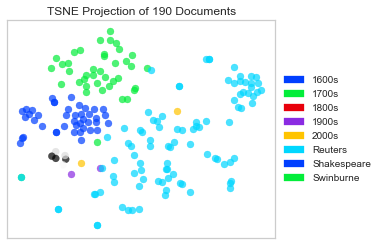

In [91]:
# Fit tf-idf vectorizer
TF_IDF = TfidfVectorizer()
docs = TF_IDF.fit_transform(corpus.data)

# Set color palette for plotting
set_palette('sns_bright')

# Construct visualizer and draw vectors
tsne = TSNEVisualizer(colors=('r','b'))
tsne.fit(docs, corpus.target)
tsne.poof()


## Feature visualization

In [37]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=10, n_iter=7)


In [38]:
def predict(clf, model, doc):
    print("Prediction for model: " + model)
    print(clf.predict([doc]))

# Demos

In [39]:
from os import listdir
from os.path import isfile, join


def runCentury(century, clf, desc):
    print("Classification of documents from the " + century)

    onlyfiles = [f for f in listdir("TextData/"+century) if isfile(join("TextData/"+century, f))]

    for f in onlyfiles:
        doc = []
        with open(filename, encoding="utf8") as f:
            doc = vectorize(f, vocab)

        predict(clf, desc, doc)


In [40]:
clfBernoulli = BernoulliNB()
clfBernoulli.fit(X,y)

clfGaussian = GaussianNB()
clfGaussian.fit(X,y)

clfLR = LogisticRegression()
clfLR.fit(X,y)

clfKnn = KNeighborsClassifier(n_neighbors=5)
clfKnn.fit(X,y)

clfSVM = svm.SVC()
clfSVM.fit(X,y)

models = [(clfBernoulli, "Bernoulli Naive Bayes"), (clfGaussian, "Gaussian Naive Bayes"), (clfLR, "Logistic Regression"), (clfKnn, "K Nearest Neighbours"), (clfSVM, "Support Vector Machine")]

/Users/sanchitsinha/Documents/UCI/cs178/cs178Venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sanchitsinha/Documents/UCI/cs178/cs178Venv/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [41]:
centuries = ["1600s","1700s","1800s","1900s","2000s"]
for c in centuries:
    for clf in models:
        runCentury(c,clf[0],clf[1])

Classification of documents from the 1600s


NameError: name 'filename' is not defined